<a href="https://colab.research.google.com/github/BrianMwangi21/btc-price-prediction-TIMESERIES/blob/main/BTC_TimeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
bc = pd.read_csv('BTC-USD.csv')
bc.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2021-04-05,58760.875000,59891.296875,57694.824219,59057.878906,59057.878906,6.070627e+10
362,2021-04-06,59171.933594,59479.578125,57646.808594,58192.359375,58192.359375,6.605803e+10
363,2021-04-07,58186.507813,58731.144531,55604.023438,56048.937500,56048.937500,7.564530e+10
364,2021-04-08,56099.914063,58338.738281,55879.085938,58323.953125,58323.953125,5.305386e+10
365,2021-04-09,58151.191406,58936.378906,57835.808594,58680.183594,58680.183594,4.973178e+10


In [3]:
bc['Date'] = pd.to_datetime(bc.Date)
bc.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [4]:
bc.set_index('Date', inplace=True)
bc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-09,7337.966309,7341.448242,7179.094238,7302.089355,7302.089355,3.481514e+10
2020-04-10,7303.815430,7303.815430,6802.475098,6865.493164,6865.493164,4.362284e+10
2020-04-11,6867.440430,6926.069824,6789.920898,6859.083008,6859.083008,3.122209e+10
2020-04-12,6858.067871,7119.947266,6811.078125,6971.091797,6971.091797,3.575957e+10
2020-04-13,6965.616699,6965.616699,6668.259766,6845.037598,6845.037598,3.861931e+10


In [5]:
bc = bc[['Close']].loc['2017-01-01':]
bc.head()

,Close
Date,
2020-04-09,7302.089355
2020-04-10,6865.493164
2020-04-11,6859.083008
2020-04-12,6971.091797
2020-04-13,6845.037598


In [6]:
# Export the data for later use
with open("curr_bitcoin.pickle", 'wb') as fp:
    pickle.dump(bc, fp)

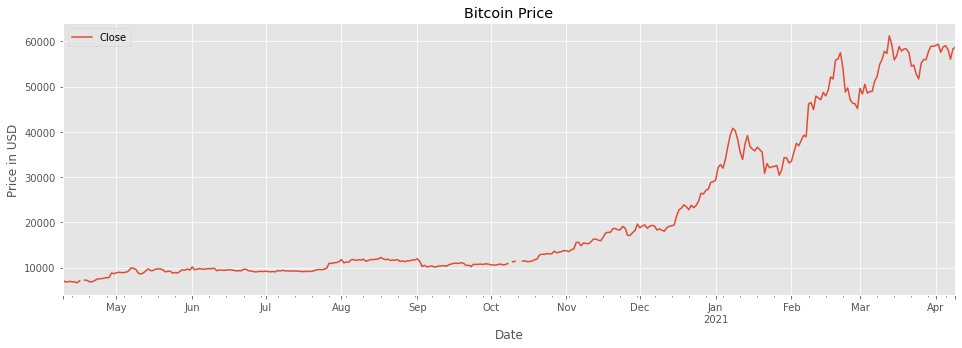

In [7]:
# Plot historical prices
bc.plot(figsize=(16,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

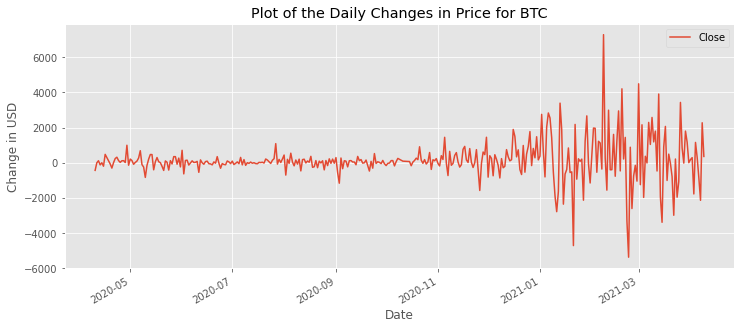

In [8]:
# Detrending 
# Method 1 - Differencing the data
# Differencing the price
bc_diff = bc.diff(1).dropna()

# Plotting the differences daily
bc_diff.plot(figsize=(12,5))
plt.title('Plot of the Daily Changes in Price for BTC')
plt.ylabel('Change in USD')
plt.show()

In [9]:
# Testing for stationarity
results = adfuller(bc_diff.Close)
print(f"P-value: {results[1]}")

P-value: 2.962929891749333e-08


In [10]:
# Method 2 - Taking the log then differencing
bc_log = pd.DataFrame(np.log(bc.Close))

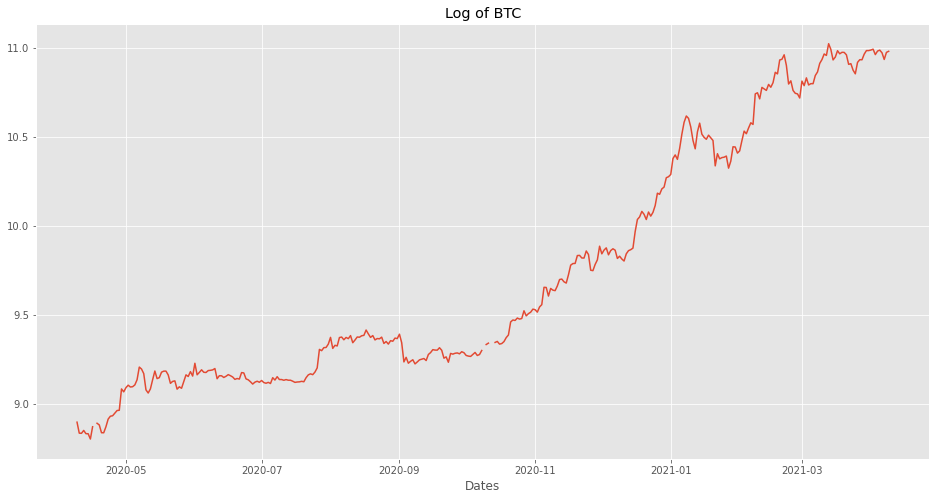

In [11]:
# Plotting the log of the data
plt.figure(figsize=(16,8))
plt.plot(bc_log)

plt.title('Log of BTC')
plt.xlabel('Dates')

plt.savefig('btc_log.png')
plt.show()

In [12]:
# Differencing the log values
log_diff = bc_log.diff().dropna()

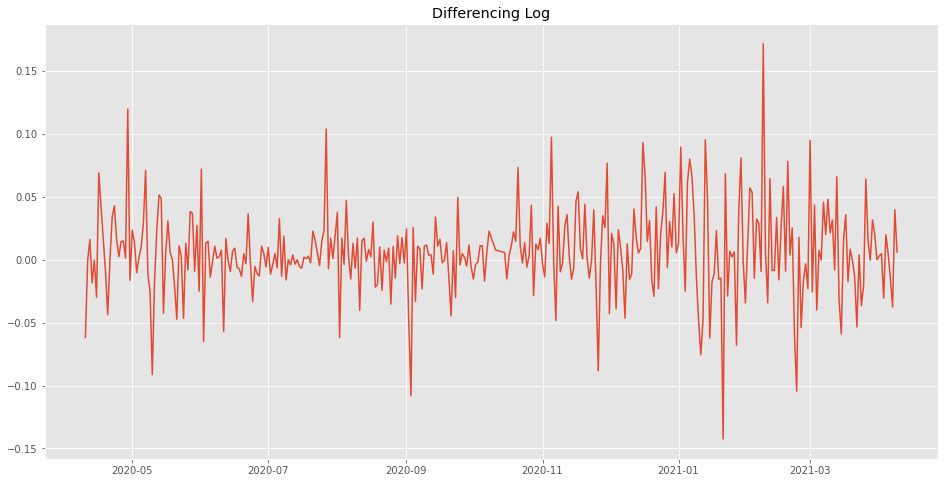

In [13]:
# Plotting the daily log difference
plt.figure(figsize=(16,8))
plt.plot(log_diff)
plt.title('Differencing Log')
plt.savefig('logdiff.png')
plt.show()

In [14]:
# Testing for stationarity
results = adfuller(log_diff.Close)
print(f"P-value: {results[1]}")

P-value: 0.0


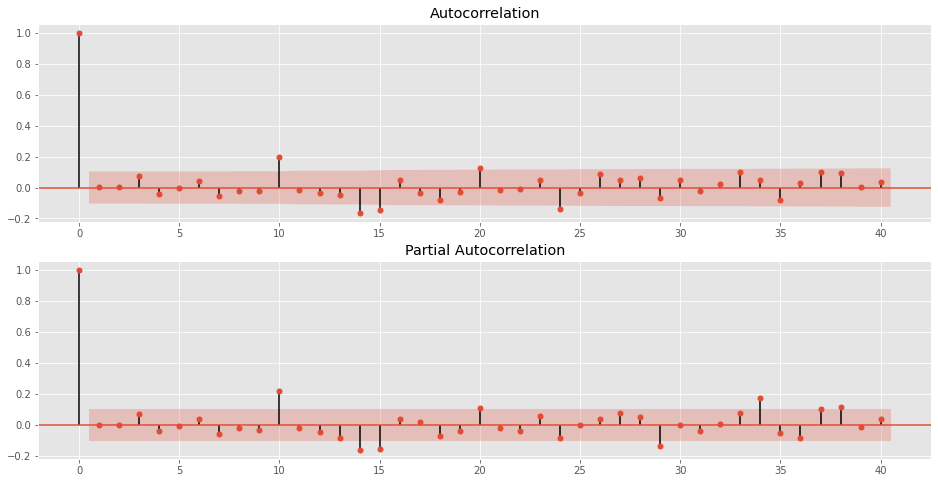

In [15]:
# PACF and ACF
# ACF and PACF for the Differencing
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(bc_diff, ax=ax1, lags=40)
plot_pacf(bc_diff, ax=ax2, lags=40)
plt.show()

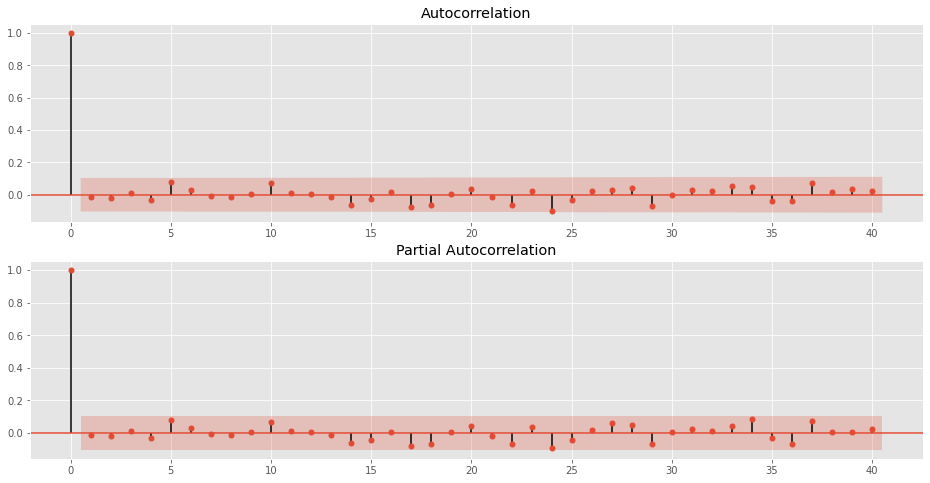

In [16]:
# PACF and ACF
# ACF and PACF for the Log Difference
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(log_diff, ax=ax1, lags=40)
plot_pacf(log_diff, ax=ax2, lags=40)
plt.savefig('acfpacf.png')
plt.show()

In [17]:
# SARIMA Model for Differencing
# Finding the Best Parameters for ARIMA
def best_param(model, data, pdq, pdqs):
    """
    Loops through each possible combo for pdq and pdqs
    Runs the model for each combo
    Retrieves the model with lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D')

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

In [18]:
# Assigning variables for p, d, q.
p = d = q = range(0,6)
d = range(2)

# Creating a list of all possible combinations of p, d, and q.
pdq = list(itertools.product(p, d, q))

# Keeping seasonality at zeroes
pdqs = [(0,0,0,0)]

In [19]:
# Finding the best parameters
best_param(SARIMAX, bc_log, pdq, pdqs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq        (1, 0, 0)
pdqs    (0, 0, 0, 0)
aic         -1399.69
Name: 12, dtype: object

In [20]:
# Fitting and Training SARIMAX
# Splitting 70/30
index = round(len(bc)*.70)

train = bc_log.iloc[:index]
test = bc_log.iloc[index:]

In [21]:
# Fitting the model to the training set
model = SARIMAX(train, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  256
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 531.436
Date:                Wed, 14 Apr 2021   AIC                          -1058.872
Time:                        07:46:28   BIC                          -1051.789
Sample:                    04-09-2020   HQIC                         -1056.023
                         - 12-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0005      0.000   5109.201      0.000       1.000       1.001
sigma2         0.0008   4.76e-05     17.670      0.000       0.001       0.001
Ljung-Box (Q):                       34.45   Jarque-

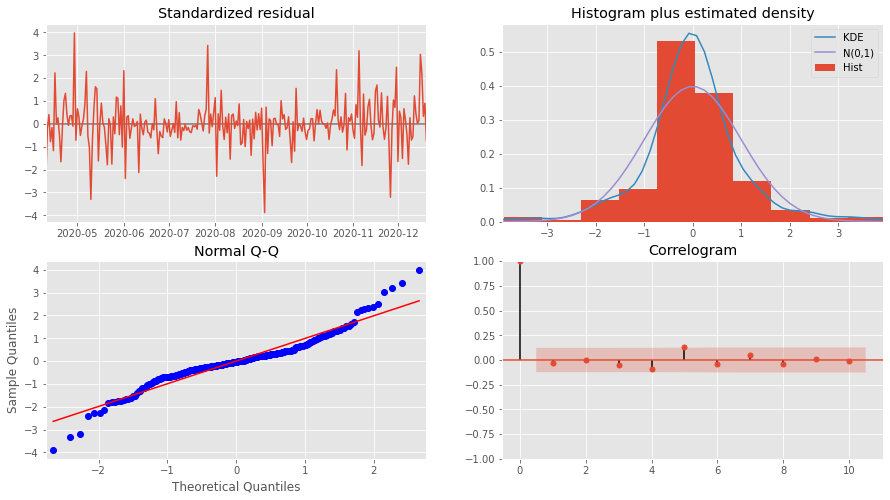

In [22]:
# Summary and Diagnostics from fitting the model
print(output.summary())
output.plot_diagnostics(figsize=(15,8))
plt.show()

In [23]:
# Predictions with ARIMA
# Transforming the Data back to its original price

# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = np.exp(pd.Series(fc.predicted_mean, index=test.index))
lower_series = np.exp(pd.Series(conf.iloc[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf.iloc[:, 1], index=test.index))

etrain = np.exp(train)
etest  = np.exp(test)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(start=pd.to_datetime('2020-04-09'), dynamic=False)
pred        = np.exp(predictions.predicted_mean)

# Confidence interval for the training set
conf_int   = np.exp(predictions.conf_int())
low_conf   = np.exp(pd.Series(conf_int.iloc[:,0], index=train.index))
upper_conf = np.exp(pd.Series(conf_int.iloc[:,1], index=train.index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


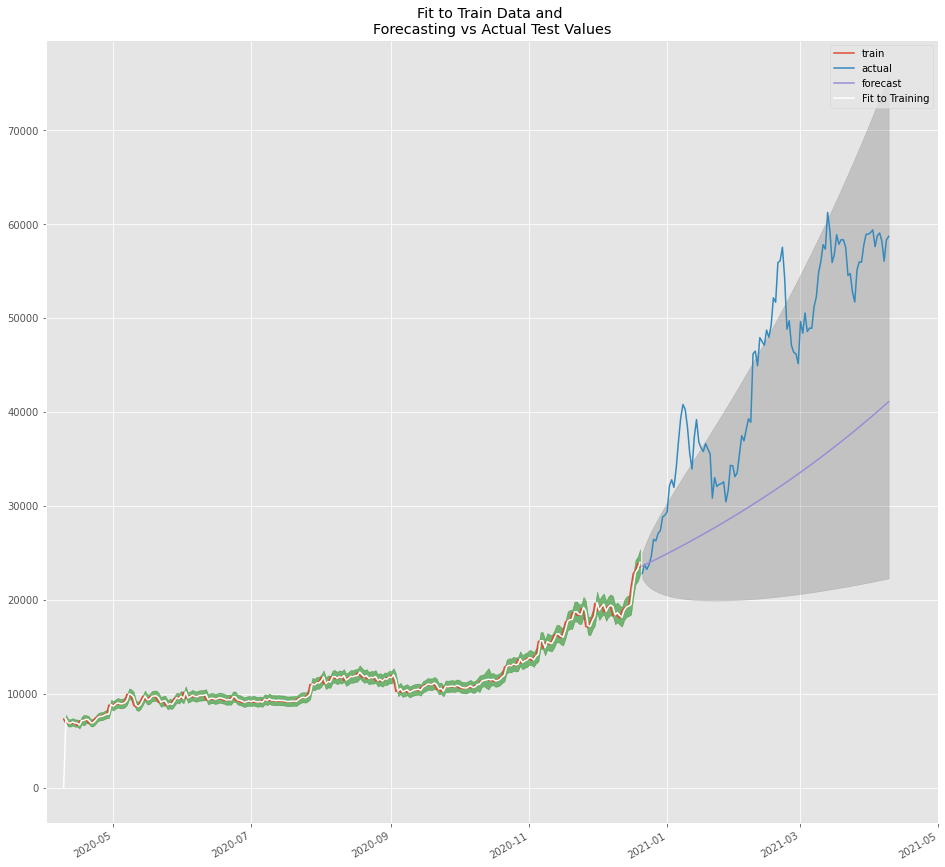

In [24]:
# Plotting the Fitted Model and Testing against the Test set
rcParams['figure.figsize'] = 16, 16

# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(etrain, label='train')
plt.plot(etest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

# Limiting the viewing size
plt.xlim(['2020-04', '2021-05'])
# plt.ylim([0, 20000])

plt.title('Fit to Train Data and \nForecasting vs Actual Test Values')
plt.legend()
plt.savefig('btc_fit_fc.png')
plt.show()

In [25]:
# For predicition
from fbprophet import Prophet as proph

In [26]:
# Load the data
with open("curr_bitcoin.pickle",'rb') as fp:
    ts = pickle.load(fp)

In [27]:
# Format the data
# Resetting the index back so Dates are no longer indexed
ts.reset_index(inplace=True)

# Renaming the columns for use in FB prophet
ts.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

ts.head()

,ds,y
0,2020-04-09,7302.089355
1,2020-04-10,6865.493164
2,2020-04-11,6859.083008
3,2020-04-12,6971.091797
4,2020-04-13,6845.037598


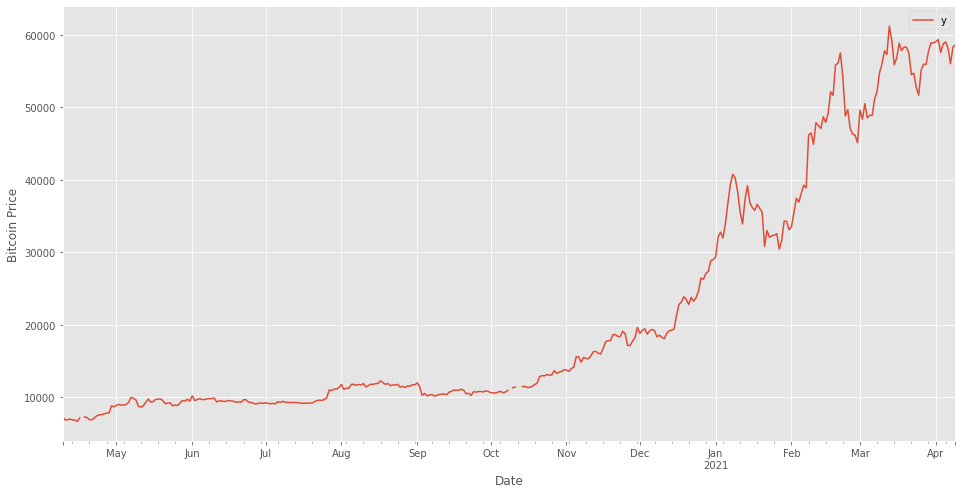

In [28]:
# Plotting the price 
pd.plotting.register_matplotlib_converters()

ax = ts.set_index('ds').plot(figsize=(16,8))
ax.set_ylabel('Bitcoin Price')
ax.set_xlabel('Date')

plt.show()

In [29]:
# Fitting and training
mod = proph(interval_width=0.95)
mod.fit(ts)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
# Create future dates for prediction
# Setting up predictions to be made
future = mod.make_future_dataframe(periods=100, freq='D')
future.tail()

,ds
461,2021-07-14
462,2021-07-15
463,2021-07-16
464,2021-07-17
465,2021-07-18


In [45]:
# Making predictions
forecast = mod.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
461,2021-07-14,95610.817930,88120.397624,101979.792993,90543.868363,100790.626470,15.898942,15.898942,15.898942,15.898942,15.898942,15.898942,0.0,0.0,0.0,95626.716873
462,2021-07-15,95953.068046,89148.156310,102961.172829,90848.095136,101208.935893,-69.563862,-69.563862,-69.563862,-69.563862,-69.563862,-69.563862,0.0,0.0,0.0,95883.504184
463,2021-07-16,96295.318163,89435.170661,103779.207809,91130.393350,101701.615150,70.556381,70.556381,70.556381,70.556381,70.556381,70.556381,0.0,0.0,0.0,96365.874544
464,2021-07-17,96637.568279,89933.266324,103714.837119,91365.914211,102136.037218,144.368583,144.368583,144.368583,144.368583,144.368583,144.368583,0.0,0.0,0.0,96781.936861
465,2021-07-18,96979.818395,90062.196868,104140.407311,91601.435073,102588.729180,-20.880097,-20.880097,-20.880097,-20.880097,-20.880097,-20.880097,0.0,0.0,0.0,96958.938299


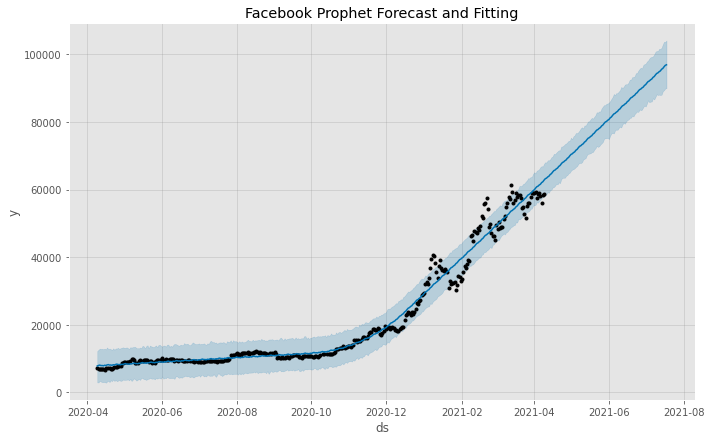

In [46]:
# Plot values
mod.plot(forecast, uncertainty=True)
plt.title('Facebook Prophet Forecast and Fitting')
plt.savefig('fb_fc_fit.png')
plt.show()

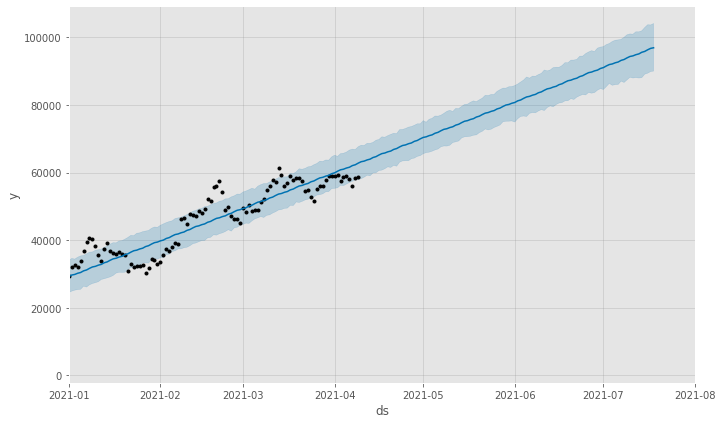

In [47]:
# Graph zoomed in
mod.plot(forecast, uncertainty=True)

from_date = pd.to_datetime('2021-01-01')
to_date = pd.to_datetime('2021-08-01')

plt.xlim([from_date, to_date])
plt.savefig('fb_zoom.png')
plt.show()

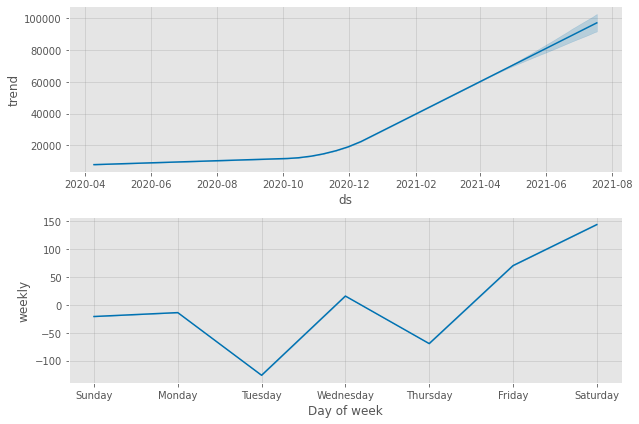

In [48]:
# Plot components
mod.plot_components(forecast)
plt.show()